# Generalizable Bayesian Logistic Regression

This notebook defines methods for easily specifying and generating Bayesian logistic regression models using our KenPom dataset. It aims to provide variable specification mechanisms and methods for testing and evaluating outcomes.

---
## Setup

This section defines required libraries and useful settings.

In [1]:
### Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pymc

In [2]:
### Settings.

# Visualization.
% matplotlib inline

### Path Settings.

# Games path.
games_path = '../../../data/games.csv'

---
## Data

This section loads data, restricts us to a single "group" of games (eliminating duplicates), and previews it.

### Load

In [208]:
# Read games.
games = pd.read_csv(games_path)
# Trim to single group.
games = games[games.game_group == 1].reset_index(drop=True)

In [222]:
# 2014 games.
games_2014 = games[games.year == 2014].reset_index(drop=True)

### Preview & Write Columns

In [209]:
games.head()

,game_id,game_group,year,date,team,opponent,conference,conference_tournament,ncaa_tournament,other_tournament,...,ratio_RankAdjOE,ratio_DE,ratio_RankDE,ratio_AdjDE,ratio_RankAdjDE,ratio_Pythag,ratio_RankPythag,points_for,points_against,win
0,20091109-albany-syracuse,1,2010,2009-11-09,Albany,Syracuse,0,0,0,0,...,29.000000,1.113412,7.757576,1.196081,15.650000,0.182429,75.250000,43,75,0
1,20091109-alcornst-ohiost,1,2010,2009-11-09,Alcorn St.,Ohio St.,0,0,0,0,...,43.250000,1.147086,8.885714,1.208579,11.366667,0.024073,49.428571,60,100,0
2,20091109-california-murrayst,1,2010,2009-11-09,California,Murray St.,0,0,0,0,...,0.066667,1.102373,27.000000,1.052743,3.060606,1.070869,0.444444,75,70,1
3,20091109-fiu-northcarolina,1,2010,2009-11-09,North Carolina,FIU,0,0,0,0,...,0.439655,0.887290,0.328402,0.846043,0.116766,4.437148,0.205387,88,72,1
4,20091111-california-detroit,1,2010,2009-11-11,Detroit,California,0,0,0,0,...,40.400000,0.966731,0.437037,0.965086,0.495050,0.695875,5.950000,61,95,0


In [5]:
# Print columns. Make them pretty.
for c_i, c in enumerate(games.columns):
    if c_i > 0 and c_i % 5 == 0:
        print
    print c.ljust(22),

game_id                game_group             year                   date                   team                  
opponent               conference             conference_tournament  ncaa_tournament        other_tournament      
location_Away          location_Home          location_Neutral       location_SemiAway      location_SemiHome     
team_Tempo             team_RankTempo         team_AdjTempo          team_RankAdjTempo      team_OE               
team_RankOE            team_AdjOE             team_RankAdjOE         team_DE                team_RankDE           
team_AdjDE             team_RankAdjDE         team_Pythag            team_RankPythag        opponent_Tempo        
opponent_RankTempo     opponent_AdjTempo      opponent_RankAdjTempo  opponent_OE            opponent_RankOE       
opponent_AdjOE         opponent_RankAdjOE     opponent_DE            opponent_RankDE        opponent_AdjDE        
opponent_RankAdjDE     opponent_Pythag        opponent_RankPythag    diff_Tempo 

---
## Utility Functions

In [ ]:
# Taken from HW4 solutions
# Geweke function
def Geweke(trace, intervals, length):
    # take two parts of the chain. 
    # subsample lenght 
    nsl=length
    jump = int(0.9*len(trace)/(2*intervals))
    first = 0.1*len(trace)
    z =np.empty(intervals)
    for k in np.arange(0, intervals):
        # beg of each sub samples
        bega=first+k*jump
        begb = len(trace)/2 + k*jump
        
        sub_trace_a = trace[bega:bega+nsl]
        sub_trace_b = trace[begb:begb+nsl]
        
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # only compute autocorrelation at lag 1-0.1*nsl.
        for i in xrange(int(0.1*nsl)):
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # estimate the variance roughly
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

In [ ]:
# Taken from lab4
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

def neff(x, T):
    n = len(x)
    rho = 1.0
    for i in xrange(T):
        rho += 2*rhot(x, i+1)
    return n/rho

In [ ]:
def plot_Geweke(model_mcmc, features):
    plt.figure(figsize=[15,5])
    for feature in features:
        geweke_MC = Geweke(model_mcmc.trace("b_"+feature)[:], 10, 1000)
        plt.plot(geweke_MC, label=feature)
    plt.axhline(y=2,color = 'k')
    plt.axhline(y=-2,color = 'k')

    plt.legend()
    plt.show()

---
## Modeling Functions

The functions defined here will perform actual modeling. They can be used to specify features and distributions.

In [225]:
"""
Inputs:
    data: 
    features: 
    coef_dists: 
    b0_params: 
    err_params:
    default_coef_dist: Coefficient distributions.
    default_coef_params: Coefficient distribution parameters.
    step_method: MCMC stepping method.
    step_method_params: Parameters for stepping method. 
"""
def model_games (
    data=games,
    features=['team_Pythag'],
    coef_dists=None,
    b0_params={'mu':0, 'tau':0.0003, 'value':0},
    err_params=[.5],
    default_coef_dist = pymc.Normal,
    default_coef_params = {'mu':0, 'tau':0.0003, 'value':0},
    step_method = pymc.Metropolis,
    step_method_params = {'proposal_sd':1., 'proposal_distribution':'Normal'}
):
    
    # Define priors on intercept and error. PyMC uses precision (inverse variance).
    b0 = pymc.Normal('b_0', **b0_params)
    err = pymc.Bernoulli('err', *err_params)
    
    # Containers for coefficients and data.
    b = np.empty(len(features), dtype=object)
    x = np.empty(len(features), dtype=object)
    
    # Traverse features.
    for i, f in enumerate(features):
        # Coefficient.
        # First start with the distribution. Use one if we've been given one; else use default.
        coef_dist_type = default_coef_dist if coef_dists is None or coef_dists[i] is None or coef_dists[i][0] is None else coef_dists[i][0]
        # Now handle parameters.
        coef_dist_params = default_coef_params if coef_dists is None or coef_dists[i] is None or coef_dists[i][1] is None else coef_dists[i][1]
        # Now actually create the coefficient distribution
        b[i] = coef_dist_type('b_'+f, **coef_dist_params)
        # Data distribution.
        x[i] = pymc.Normal('x_'+f, 0, 1, value=np.array(data[f]), observed=True)
    
    # Logistic function.
    @pymc.deterministic
    def logistic(b0=b0, b=b, x=x):
        return 1.0 / (1. + np.exp(-(b0 + b.dot(x))))

    # Get outcome data.
    y = np.array(data.win)
    # Model outcome as a Bernoulli distribution.
    y = pymc.Bernoulli('win', logistic, value=y, observed=True)
    
    # Define model, MCMC object.
    model = pymc.Model([logistic, pymc.Container(b), err, pymc.Container(x), y])
    mcmc  = pymc.MCMC(model)
    
    # Configure step methods.
    for var in list(b)+[b0,err]:
        mcmc.use_step_method(step_method, stochastic=var, **step_method_params)
    
    # Return MCMC object.
    return mcmc

In [ ]:
# Return the means of the pymc coefficients
# model_mcmc: pymc model
# features:   list of features in pymc
def mcmc_trace_means(model_mcmc, features, printMeans = False):
    means = []
    for feature in features:
        mean = model_mcmc.trace("b_"+feature)[:].mean()
        if printMeans:
            print "b_"+feature, mean
        means.append(mean)
    return np.array(means)

---
### Using

Here are some simple uses of the modeling functions above.

In [226]:
# Features.
features = ['location_Home','diff_Tempo','diff_OE','diff_DE','diff_Pythag']
model_mcmc = model_games(data=games_2014,features=features)

In [227]:
model_mcmc.sample(10000,2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 19.1 sec

In [61]:
print model_mcmc.trace('b_0')[:].mean()
print model_mcmc.trace('b_diff_Pythag')[:].mean()

-0.523045979292
5.74338163856


In [ ]:
model_means = mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

In [ ]:
### Model Diagnostics

In [ ]:
plot_Geweke(model_mcmc, [str(0)]+features)

---
## Predictions

In [300]:
"""
Inputs:
    data:       Dataframe with game data.
    model_mcmc: PyMC MCMC object.
    features:   list of features in data dataframe.
    method:     'pp' for posterior predictive, 'map' for single estimate using MAP.
"""
def predict_games (data, model_mcmc, features, method='pp'):
    # Trace and feature length.
    trace_len = model_mcmc.trace('b_0')[:].shape[0]
    coef_samples = trace_len
    feat_len  = len(features)+1
    data_len  = len(data)
    
    # Get coefficients.
    coefs = np.empty((trace_len,feat_len))
    for f_i, f in enumerate(['0']+features):
        coefs[:,f_i] = model_mcmc.trace('b_'+f)[:]
    # Use MAP if we need to.
    if method == 'map':
        coefs = coefs.mean(axis=0).reshape((1,feat_len))
        coef_samples = 1
    
    # Get design matrix.
    X = np.ones((data_len,feat_len))
    for f_i, f in enumerate(features):
        X[:,f_i+1] = data.ix[:,f]
    # Get wins.
    y = np.array(data.win)
    
    # Logistic function for win calculation.
    logistic = lambda s: 1 / (1+np.exp(-s))
    
    # Estimate wins. Start with a wins container.
    y_hat_raw = np.zeros((coef_samples,data_len))
    y_hat     = np.zeros((coef_samples,data_len), dtype=np.int)
    # Traverse set of coefficients and assemble win estimates.
    for c_i, c in enumerate(coefs):
        y_hat_raw[c_i] = logistic((c.T*X).sum(axis=1))
    # Tag wins/losses with comparison.
    y_hat = (y_hat_raw >= .5).astype(np.int)
    
    # Compute accuracy by wins.
    y_hat_accuracy = (y == y_hat).mean()
    
    return y_hat_raw, y_hat, y_hat_accuracy

In [304]:
y_hat_raw, y_hat, y_hat_accuracy = predict_games(games_2014, model_mcmc, features, 'pp')

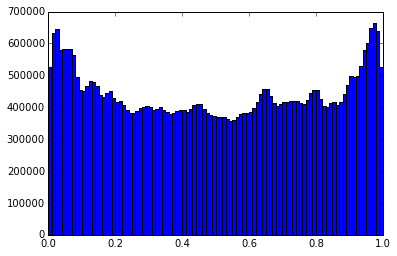

In [305]:
plt.hist(y_hat_raw.ravel(), bins=100);